# CNN Autoencoder for Particle Physics Anomaly Detection

This notebook implements and trains a 1D CNN autoencoder for anomaly detection in particle physics events. The model processes events as sequences of points [x, y, z, energy] sorted by energy to create meaningful local structure for the CNN to learn from.

## Key Features:
- **Input**: Variable-length point sequences sorted by energy (highest to lowest)
- **Architecture**: 1D CNN with encoder-decoder structure
- **Padding**: Dynamic padding to handle variable event sizes
- **Anomaly Detection**: Reconstruction loss-based approach
- **Scalability**: Linear scaling with number of points (vs quadratic for graphs)

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import glob
import os
from tqdm import tqdm
import time
from multiprocessing import Pool, cpu_count

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Style for plots
plt.style.use('default')
sns.set_palette("husl")

Using device: cuda


In [4]:
# Configuration
CONFIG = {
    'data_path': '/nevis/riverside/data/sc5303/sbnd/offline_ad/pi0/npy/*.npy',
    'max_points': 10000,  # Maximum number of points per event
    'min_points': 10,    # Minimum number of points per event
    'max_files': 5,      # Limit number of files for testing
    'batch_size': 16,    # Batch size for training
    'learning_rate': 1e-3,
    'num_epochs': 50,
    'latent_dim': 128,
    'test_split': 0.2,
    'val_split': 0.1,
    'num_workers': 4,
    'feature_dim': 4,    # [x, y, z, energy]
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Find available data files
data_files = sorted(glob.glob(CONFIG['data_path']))
if CONFIG['max_files']:
    data_files = data_files[:CONFIG['max_files']]

print(f"\nFound {len(data_files)} data files:")
for file in data_files:
    file_size = os.path.getsize(file) / (1024**2)  # MB
    print(f"  {os.path.basename(file)} ({file_size:.1f} MB)")

Configuration:
  data_path: /nevis/riverside/data/sc5303/sbnd/offline_ad/pi0/npy/*.npy
  max_points: 10000
  min_points: 10
  max_files: 5
  batch_size: 16
  learning_rate: 0.001
  num_epochs: 50
  latent_dim: 128
  test_split: 0.2
  val_split: 0.1
  num_workers: 4
  feature_dim: 4

Found 5 data files:
  larcv_mc_20250805_180619_148799_24dc9fe4-a1d5-4beb-b535-f839a2e22cc3.npy (2.6 MB)
  larcv_mc_20250805_180756_341034_e95d0665-b7ab-4a26-a855-26f4ddc70282.npy (2.6 MB)
  larcv_mc_20250805_180826_660192_ae838e9b-8335-4a3f-9b4d-73469408c415.npy (2.6 MB)
  larcv_mc_20250805_180839_237800_810b09a9-4afb-43a0-83c2-78aa096df2c2.npy (2.6 MB)
  larcv_mc_20250805_180950_618755_41f26eea-3975-4062-8089-2cf700bbbd30.npy (2.6 MB)


Starting data loading...
Loading all data files...


Loading files:  40%|████      | 2/5 [00:00<00:00, 11.45it/s]

Loading larcv_mc_20250805_180619_148799_24dc9fe4-a1d5-4beb-b535-f839a2e22cc3.npy: shape (136446, 5)
  Loaded 32 valid events
Loading larcv_mc_20250805_180756_341034_e95d0665-b7ab-4a26-a855-26f4ddc70282.npy: shape (135477, 5)
  Loaded 32 valid events
Loading larcv_mc_20250805_180826_660192_ae838e9b-8335-4a3f-9b4d-73469408c415.npy: shape (138107, 5)


Loading files: 100%|██████████| 5/5 [00:00<00:00, 16.66it/s]



  Loaded 32 valid events
Loading larcv_mc_20250805_180839_237800_810b09a9-4afb-43a0-83c2-78aa096df2c2.npy: shape (136564, 5)
  Loaded 32 valid events
Loading larcv_mc_20250805_180950_618755_41f26eea-3975-4062-8089-2cf700bbbd30.npy: shape (135643, 5)
  Loaded 32 valid events

Total events loaded: 160
Event size statistics:
  Min: 2710 points
  Max: 4900 points
  Mean: 4264.0 points
  Median: 4275.5 points


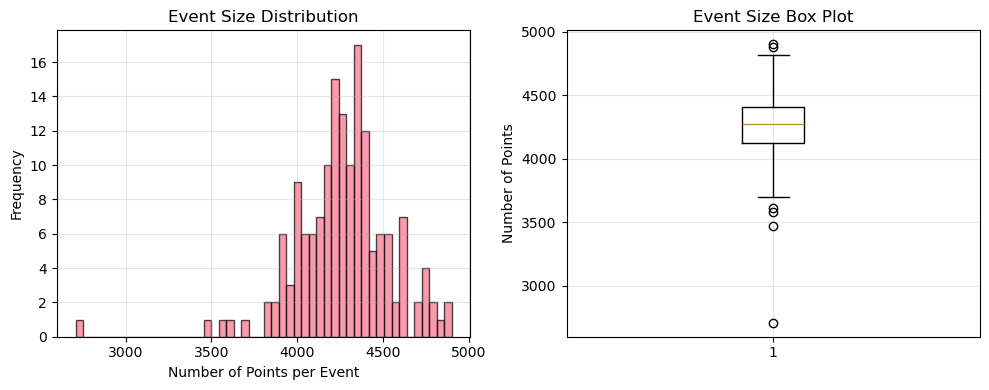

Data loading completed in 0.70 seconds


In [5]:
# Data Loading and Preprocessing Functions

def load_npy_file(file_path):
    """Load and process a single NPY file"""
    try:
        data = np.load(file_path)
        print(f"Loading {os.path.basename(file_path)}: shape {data.shape}")
        
        if data.shape[1] != 5:  # [event, x, y, z, energy]
            print(f"  Warning: Expected 5 columns, got {data.shape[1]}")
            return []
        
        # Group by event
        df = pd.DataFrame(data, columns=['event', 'x', 'y', 'z', 'energy'])
        events = []
        
        for event_id in df['event'].unique():
            event_data = df[df['event'] == event_id][['x', 'y', 'z', 'energy']].values
            
            # Filter by size
            if CONFIG['min_points'] <= len(event_data) <= CONFIG['max_points']:
                # Sort by energy (highest to lowest) - this creates structure for CNN
                sorted_indices = np.argsort(-event_data[:, 3])  # Sort by energy descending
                sorted_event = event_data[sorted_indices]
                events.append(sorted_event)
        
        print(f"  Loaded {len(events)} valid events")
        return events
        
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return []

def load_all_data(file_paths):
    """Load all data files and return list of events"""
    print("Loading all data files...")
    all_events = []
    
    for file_path in tqdm(file_paths, desc="Loading files"):
        events = load_npy_file(file_path)
        all_events.extend(events)
    
    print(f"\nTotal events loaded: {len(all_events)}")
    
    # Analyze event sizes
    if all_events:
        event_sizes = [len(event) for event in all_events]
        print(f"Event size statistics:")
        print(f"  Min: {min(event_sizes)} points")
        print(f"  Max: {max(event_sizes)} points") 
        print(f"  Mean: {np.mean(event_sizes):.1f} points")
        print(f"  Median: {np.median(event_sizes):.1f} points")
        
        # Plot size distribution
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(event_sizes, bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Number of Points per Event')
        plt.ylabel('Frequency')
        plt.title('Event Size Distribution')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.boxplot(event_sizes)
        plt.ylabel('Number of Points')
        plt.title('Event Size Box Plot')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return all_events

# Load data
print("Starting data loading...")
start_time = time.time()
all_events = load_all_data(data_files)
load_time = time.time() - start_time
print(f"Data loading completed in {load_time:.2f} seconds")

In [6]:
# Dataset Class and Normalization

class ParticleEventDataset(Dataset):
    """Dataset class for particle physics events"""
    
    def __init__(self, events, scaler=None, fit_scaler=True):
        self.events = events
        self.scaler = scaler
        
        if self.scaler is None and fit_scaler:
            # Fit scaler on all data points
            all_points = np.vstack(events)
            self.scaler = StandardScaler()
            self.scaler.fit(all_points)
            print(f"Fitted scaler on {len(all_points)} total points")
            print(f"Feature means: {self.scaler.mean_}")
            print(f"Feature stds: {self.scaler.scale_}")
        
        # Normalize events
        self.normalized_events = []
        for event in events:
            if self.scaler is not None:
                normalized_event = self.scaler.transform(event)
            else:
                normalized_event = event
            self.normalized_events.append(torch.FloatTensor(normalized_event))
    
    def __len__(self):
        return len(self.normalized_events)
    
    def __getitem__(self, idx):
        return self.normalized_events[idx]

def collate_fn(batch):
    """Custom collate function to handle variable-length sequences"""
    # Pad sequences to the same length
    padded = pad_sequence(batch, batch_first=True, padding_value=0)
    return padded

# Create dataset and split
if all_events:
    print("\nCreating dataset...")
    
    # Split data
    train_events, temp_events = train_test_split(
        all_events, test_size=CONFIG['test_split'] + CONFIG['val_split'], 
        random_state=42
    )
    
    val_events, test_events = train_test_split(
        temp_events, test_size=CONFIG['test_split'] / (CONFIG['test_split'] + CONFIG['val_split']),
        random_state=42
    )
    
    print(f"Dataset splits:")
    print(f"  Train: {len(train_events)} events")
    print(f"  Validation: {len(val_events)} events")
    print(f"  Test: {len(test_events)} events")
    
    # Create datasets
    train_dataset = ParticleEventDataset(train_events, fit_scaler=True)
    val_dataset = ParticleEventDataset(val_events, scaler=train_dataset.scaler, fit_scaler=False)
    test_dataset = ParticleEventDataset(test_events, scaler=train_dataset.scaler, fit_scaler=False)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=True, collate_fn=collate_fn, num_workers=CONFIG['num_workers']
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=False, collate_fn=collate_fn, num_workers=CONFIG['num_workers']
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=CONFIG['batch_size'],
        shuffle=False, collate_fn=collate_fn, num_workers=CONFIG['num_workers']
    )
    
    print(f"Data loaders created successfully")
    
    # Show example batch
    sample_batch = next(iter(train_loader))
    print(f"Sample batch shape: {sample_batch.shape}")
    print(f"Sample batch range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
    
else:
    print("No events loaded - cannot proceed with training")


Creating dataset...
Dataset splits:
  Train: 111 events
  Validation: 16 events
  Test: 33 events
Fitted scaler on 471056 total points
Feature means: [1.35473714e+03 1.02359267e+03 7.24992209e+02 2.19674405e-01]
Feature stds: [ 29.884935    29.65433826 131.38512972   0.15882326]
Data loaders created successfully
Sample batch shape: torch.Size([16, 4603, 4])
Sample batch range: [-16.577, 10.501]
Sample batch shape: torch.Size([16, 4603, 4])
Sample batch range: [-16.577, 10.501]


In [7]:
# CNN Autoencoder Model

class CNN1DAutoEncoder(nn.Module):
    """
    1D CNN Autoencoder for particle physics events.
    
    Input: (batch_size, sequence_length, 4) where 4 = [x, y, z, energy]
    Output: (batch_size, sequence_length, 4) reconstructed input
    """
    
    def __init__(self, input_dim=4, latent_dim=128, max_seq_length=4000):
        super(CNN1DAutoEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.max_seq_length = max_seq_length
        
        # Encoder
        self.encoder = nn.Sequential(
            # First conv block
            nn.Conv1d(input_dim, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Dropout(0.1),
            
            # Second conv block
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Dropout(0.1),
            
            # Third conv block
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Dropout(0.1),
            
            # Fourth conv block
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(latent_dim // 4),  # Adaptive pooling to fixed size
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Linear(512 * (latent_dim // 4), latent_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(latent_dim, 512 * (latent_dim // 4)),
            nn.ReLU(inplace=True),
        )
        
        # Decoder  
        self.decoder = nn.Sequential(
            # First deconv block
            nn.ConvTranspose1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=False),
            nn.Dropout(0.1),
            
            # Second deconv block
            nn.ConvTranspose1d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=False),
            nn.Dropout(0.1),
            
            # Third deconv block
            nn.ConvTranspose1d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=False),
            nn.Dropout(0.1),
            
            # Output layer
            nn.ConvTranspose1d(64, input_dim, kernel_size=7, padding=3),
        )
        
    def encode(self, x):
        # x: (batch_size, seq_len, input_dim)
        x = x.transpose(1, 2)  # -> (batch_size, input_dim, seq_len)
        
        encoded = self.encoder(x)  # -> (batch_size, 512, latent_dim//4)
        
        # Flatten for bottleneck
        batch_size = encoded.size(0)
        encoded = encoded.view(batch_size, -1)
        
        # Pass through bottleneck
        bottleneck = self.bottleneck(encoded)
        
        return bottleneck
    
    def decode(self, bottleneck, target_length):
        # Reshape back to conv format
        batch_size = bottleneck.size(0)
        reshaped = bottleneck.view(batch_size, 512, self.latent_dim // 4)
        
        # Pass through decoder
        decoded = self.decoder(reshaped)  # -> (batch_size, input_dim, some_length)
        
        # Interpolate to target length
        if decoded.size(2) != target_length:
            decoded = F.interpolate(decoded, size=target_length, mode='linear', align_corners=False)
        
        decoded = decoded.transpose(1, 2)  # -> (batch_size, seq_len, input_dim)
        
        return decoded
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Encode
        bottleneck = self.encode(x)
        
        # Decode to original length
        reconstructed = self.decode(bottleneck, seq_len)
        
        return reconstructed

# Create model
if all_events:
    model = CNN1DAutoEncoder(
        input_dim=CONFIG['feature_dim'],
        latent_dim=CONFIG['latent_dim'],
        max_seq_length=CONFIG['max_points']
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model created successfully!")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Model size: {total_params * 4 / (1024**2):.2f} MB")
    
    # Test forward pass
    with torch.no_grad():
        sample_input = sample_batch[:2].to(device)  # Take 2 samples
        sample_output = model(sample_input)
        print(f"Test forward pass:")
        print(f"  Input shape: {sample_input.shape}")
        print(f"  Output shape: {sample_output.shape}")
        print(f"  Input range: [{sample_input.min():.3f}, {sample_input.max():.3f}]")
        print(f"  Output range: [{sample_output.min():.3f}, {sample_output.max():.3f}]")
else:
    print("No data available - cannot create model")

Model created successfully!
Total parameters: 5,283,588
Trainable parameters: 5,283,588
Model size: 20.16 MB
Test forward pass:
  Input shape: torch.Size([2, 4603, 4])
  Output shape: torch.Size([2, 4603, 4])
  Input range: [-8.552, 9.278]
  Output range: [-6.818, 4.776]
Test forward pass:
  Input shape: torch.Size([2, 4603, 4])
  Output shape: torch.Size([2, 4603, 4])
  Input range: [-8.552, 9.278]
  Output range: [-6.818, 4.776]


In [8]:
# Training Functions

def create_padding_mask(x, padding_value=0.0):
    """Create mask for padded sequences"""
    # Check if all features in a point are padding
    mask = ~(x.abs().sum(dim=-1) == padding_value)  # (batch_size, seq_len)
    return mask

def masked_mse_loss(output, target, mask=None):
    """MSE loss that ignores padded positions"""
    if mask is None:
        return F.mse_loss(output, target)
    
    # Expand mask to match feature dimensions
    mask = mask.unsqueeze(-1)  # (batch_size, seq_len, 1)
    
    # Apply mask
    masked_output = output * mask.float()
    masked_target = target * mask.float()
    
    # Calculate loss only on non-padded positions
    loss = F.mse_loss(masked_output, masked_target, reduction='none')
    
    # Sum over features and sequence, then average over valid positions
    loss = loss.sum() / mask.sum().float()
    
    return loss

def train_epoch(model, dataloader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Create mask for padded positions
        mask = create_padding_mask(batch)
        
        # Forward pass
        reconstructed = model(batch, mask=mask)
        
        # Calculate loss
        loss = masked_mse_loss(reconstructed, batch, mask)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    return total_loss / num_batches

def validate_epoch(model, dataloader, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            batch = batch.to(device)
            
            # Create mask
            mask = create_padding_mask(batch)
            
            # Forward pass
            reconstructed = model(batch, mask=mask)
            
            # Calculate loss
            loss = masked_mse_loss(reconstructed, batch, mask)
            
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

# Training setup
if all_events:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, verbose=True
    )
    
    # Training history
    train_losses = []
    val_losses = []
    
    print("Training setup complete!")
    print(f"Optimizer: Adam with lr={CONFIG['learning_rate']}")
    print(f"Scheduler: ReduceLROnPlateau")
    print(f"Training for {CONFIG['num_epochs']} epochs")
else:
    print("No data available - cannot setup training")

Training setup complete!
Optimizer: Adam with lr=0.001
Scheduler: ReduceLROnPlateau
Training for 50 epochs


/nevis/riverside/data/sc5303/conda_environments/envs/anomaly_torch_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...

Epoch 1/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]



Train Loss: 8.621385 | Val Loss: 3.454151 | LR: 1.00e-03
New best model saved! Val Loss: 3.454151

Epoch 2/50
New best model saved! Val Loss: 3.454151

Epoch 2/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



Train Loss: 3.988415 | Val Loss: 3.121739 | LR: 1.00e-03
New best model saved! Val Loss: 3.121739

Epoch 3/50
New best model saved! Val Loss: 3.121739

Epoch 3/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]



Train Loss: 3.505214 | Val Loss: 3.108700 | LR: 1.00e-03
New best model saved! Val Loss: 3.108700

Epoch 4/50
New best model saved! Val Loss: 3.108700

Epoch 4/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Train Loss: 3.362834 | Val Loss: 3.131419 | LR: 1.00e-03

Epoch 5/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Train Loss: 3.183086 | Val Loss: 3.069137 | LR: 1.00e-03
New best model saved! Val Loss: 3.069137

Epoch 6/50
New best model saved! Val Loss: 3.069137

Epoch 6/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]



Train Loss: 3.128118 | Val Loss: 3.017020 | LR: 1.00e-03
New best model saved! Val Loss: 3.017020

Epoch 7/50
New best model saved! Val Loss: 3.017020

Epoch 7/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]



Train Loss: 3.087691 | Val Loss: 2.914233 | LR: 1.00e-03
New best model saved! Val Loss: 2.914233

Epoch 8/50
New best model saved! Val Loss: 2.914233

Epoch 8/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Train Loss: 3.015011 | Val Loss: 2.817736 | LR: 1.00e-03
New best model saved! Val Loss: 2.817736

Epoch 9/50
New best model saved! Val Loss: 2.817736

Epoch 9/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]



Train Loss: 3.014040 | Val Loss: 2.794393 | LR: 1.00e-03
New best model saved! Val Loss: 2.794393

Epoch 10/50
New best model saved! Val Loss: 2.794393

Epoch 10/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Train Loss: 2.973611 | Val Loss: 2.813480 | LR: 1.00e-03

Epoch 11/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Train Loss: 2.992904 | Val Loss: 2.815601 | LR: 1.00e-03

Epoch 12/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



Train Loss: 2.967607 | Val Loss: 2.786211 | LR: 1.00e-03
New best model saved! Val Loss: 2.786211

Epoch 13/50
New best model saved! Val Loss: 2.786211

Epoch 13/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Train Loss: 2.960548 | Val Loss: 2.796630 | LR: 1.00e-03

Epoch 14/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Train Loss: 2.963224 | Val Loss: 2.792199 | LR: 1.00e-03

Epoch 15/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Train Loss: 2.936082 | Val Loss: 2.801182 | LR: 1.00e-03

Epoch 16/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Train Loss: 2.935822 | Val Loss: 2.788947 | LR: 1.00e-03

Epoch 17/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]



Train Loss: 2.919542 | Val Loss: 2.784824 | LR: 1.00e-03
New best model saved! Val Loss: 2.784824

Epoch 18/50
New best model saved! Val Loss: 2.784824

Epoch 18/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]



Train Loss: 2.920627 | Val Loss: 2.747373 | LR: 1.00e-03
New best model saved! Val Loss: 2.747373

Epoch 19/50
New best model saved! Val Loss: 2.747373

Epoch 19/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Train Loss: 2.911876 | Val Loss: 2.750273 | LR: 1.00e-03

Epoch 20/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


Train Loss: 2.890950 | Val Loss: 2.752602 | LR: 1.00e-03

Epoch 21/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]



Train Loss: 2.894783 | Val Loss: 2.733758 | LR: 1.00e-03
New best model saved! Val Loss: 2.733758

Epoch 22/50
New best model saved! Val Loss: 2.733758

Epoch 22/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Train Loss: 2.871648 | Val Loss: 2.739664 | LR: 1.00e-03

Epoch 23/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



Train Loss: 2.877183 | Val Loss: 2.728709 | LR: 1.00e-03
New best model saved! Val Loss: 2.728709

Epoch 24/50
New best model saved! Val Loss: 2.728709

Epoch 24/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Train Loss: 2.869459 | Val Loss: 2.741025 | LR: 1.00e-03

Epoch 25/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Train Loss: 2.905256 | Val Loss: 2.754282 | LR: 1.00e-03

Epoch 26/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Train Loss: 2.867772 | Val Loss: 2.739187 | LR: 1.00e-03

Epoch 27/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Train Loss: 2.864183 | Val Loss: 2.743593 | LR: 1.00e-03

Epoch 28/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



Train Loss: 2.854026 | Val Loss: 2.723737 | LR: 1.00e-03
New best model saved! Val Loss: 2.723737

Epoch 29/50
New best model saved! Val Loss: 2.723737

Epoch 29/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Train Loss: 2.849594 | Val Loss: 2.734127 | LR: 1.00e-03

Epoch 30/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Train Loss: 2.850712 | Val Loss: 2.736435 | LR: 1.00e-03

Epoch 31/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Train Loss: 2.861747 | Val Loss: 2.737225 | LR: 1.00e-03

Epoch 32/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Train Loss: 2.876953 | Val Loss: 2.735672 | LR: 1.00e-03

Epoch 33/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Train Loss: 2.870888 | Val Loss: 2.754304 | LR: 1.00e-03

Epoch 34/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Train Loss: 2.866851 | Val Loss: 2.744150 | LR: 7.00e-04

Epoch 35/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Train Loss: 2.859294 | Val Loss: 2.751066 | LR: 7.00e-04

Epoch 36/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Train Loss: 2.845165 | Val Loss: 2.755615 | LR: 7.00e-04

Epoch 37/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Train Loss: 2.851340 | Val Loss: 2.725673 | LR: 7.00e-04

Epoch 38/50


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]



Train Loss: 2.827113 | Val Loss: 2.728626 | LR: 7.00e-04
Early stopping triggered!

Training completed in 27.24 seconds
Best validation loss: 2.723737


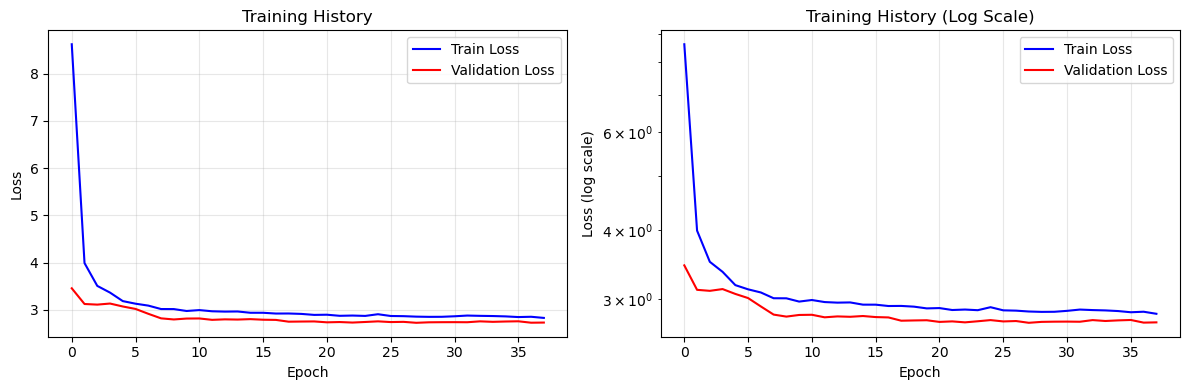

In [9]:
# Training Loop

if all_events:
    print("Starting training...")
    best_val_loss = float('inf')
    patience_counter = 0
    
    start_time = time.time()
    
    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
        
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        
        # Validation
        val_loss = validate_epoch(model, val_loader, device)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Print results
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.2e}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'config': CONFIG,
                'scaler': train_dataset.scaler
            }, 'best_cnn_autoencoder.pth')
            print(f"New best model saved! Val Loss: {val_loss:.6f}")
        else:
            patience_counter += 1
        
        # Early stopping check
        if patience_counter >= 10:
            print("Early stopping triggered!")
            break
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.semilogy(train_losses, label='Train Loss', color='blue')
    plt.semilogy(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Training History (Log Scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No data available - cannot train model")

/tmp/ipykernel_1327002/3802313821.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_cnn_autoencoder.pth')


Evaluating model on test set...
Loaded best model checkpoint


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]




Test Set Evaluation:
Number of test samples: 33
Mean reconstruction loss: 0.712198
Std reconstruction loss: 0.247723
Min reconstruction loss: 0.329613
Max reconstruction loss: 1.298210


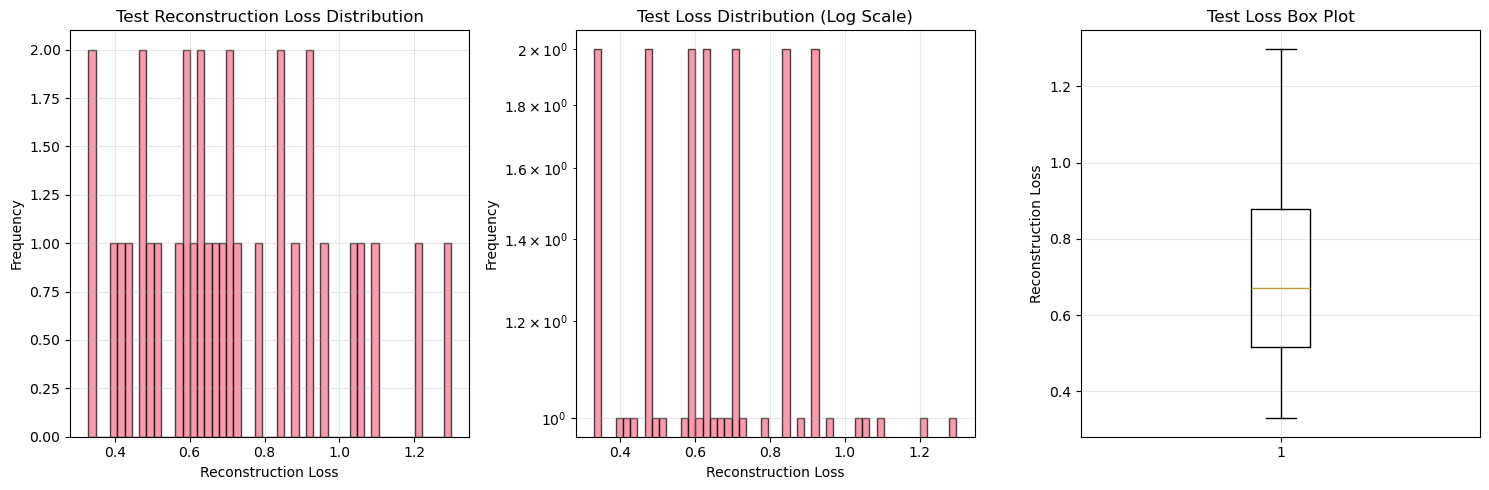


Visualizing 10 sample reconstructions...


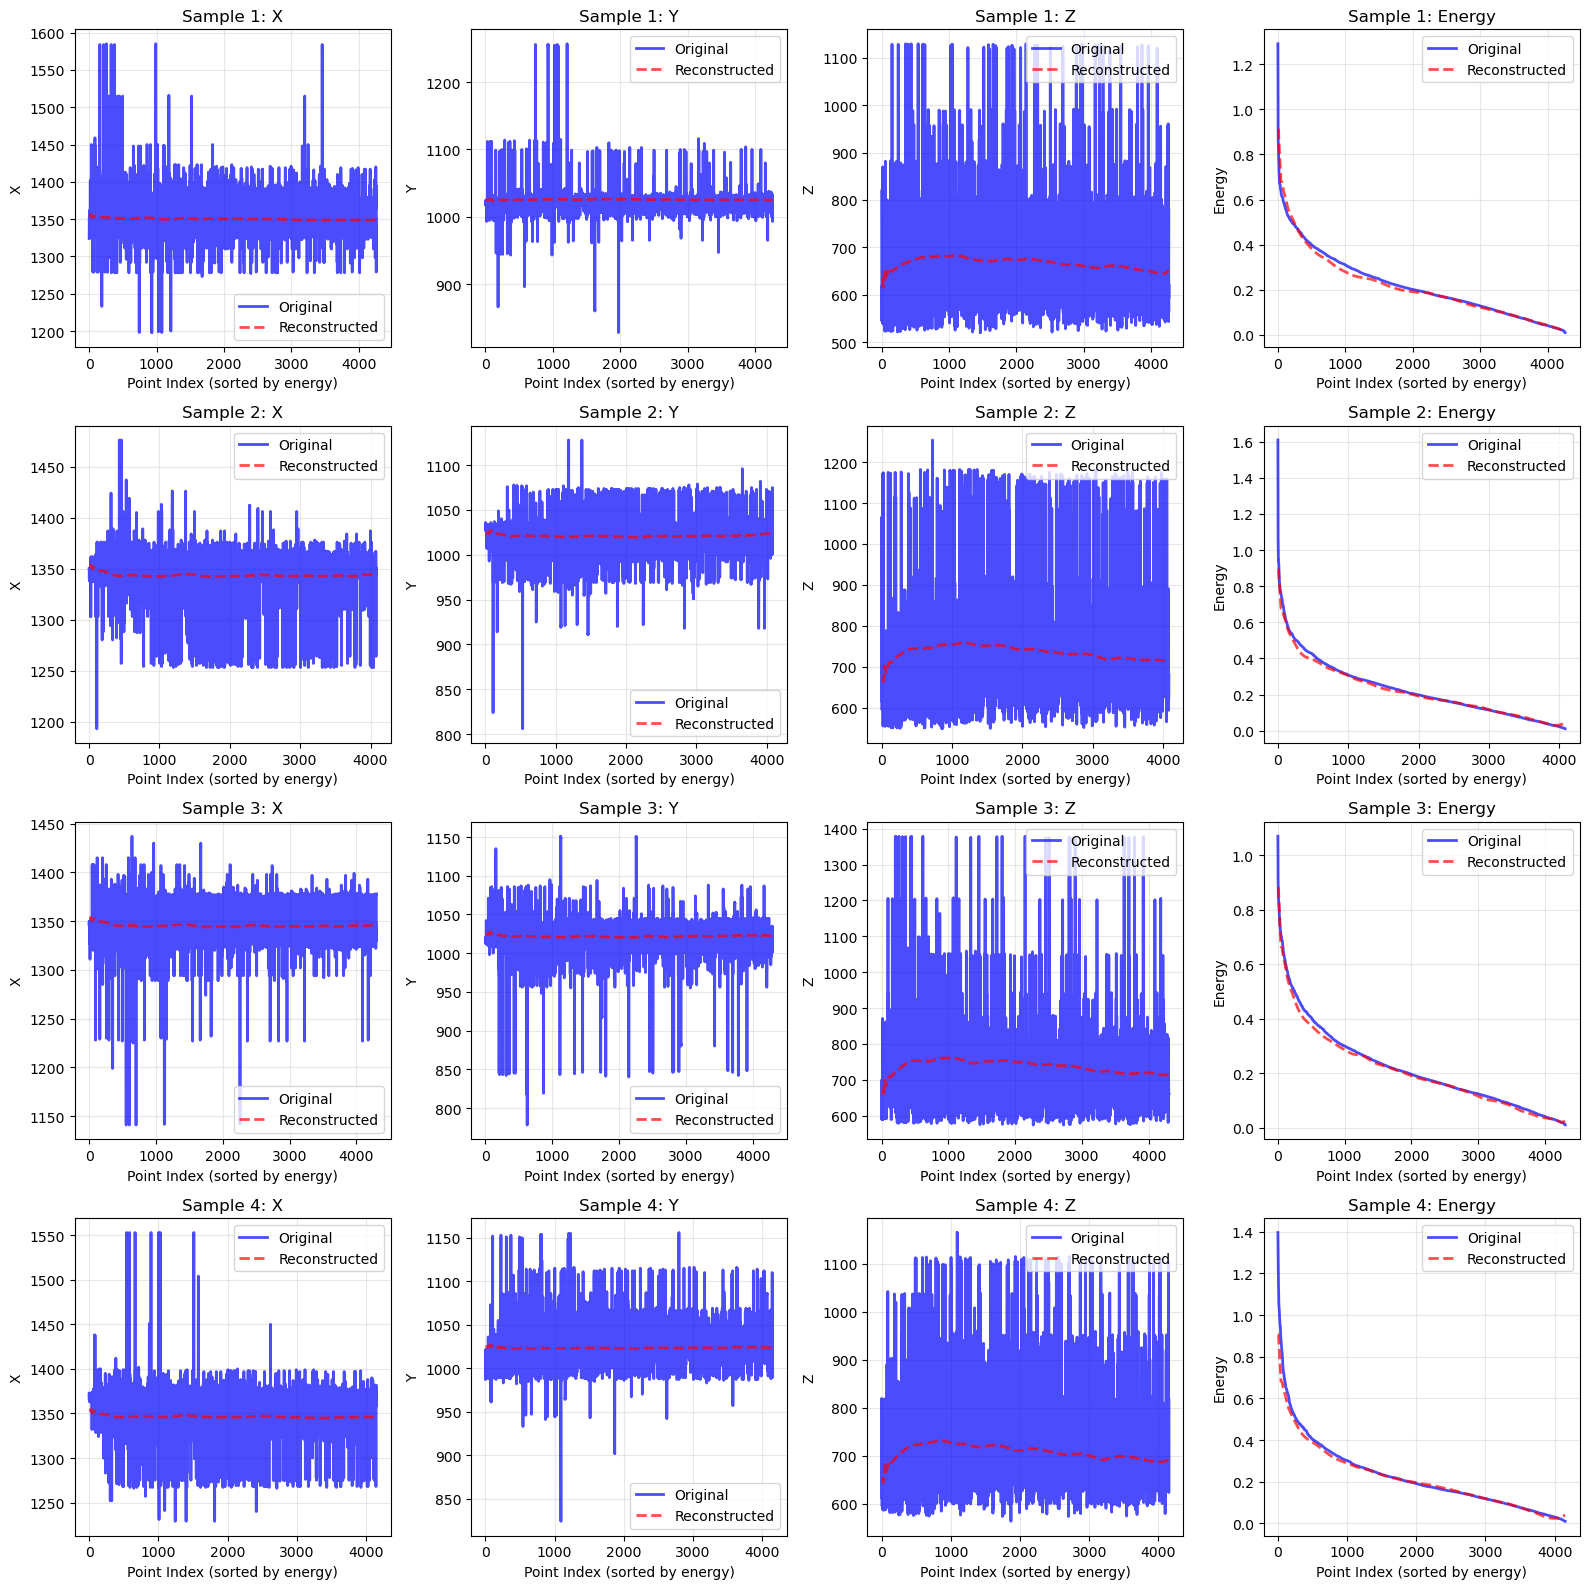

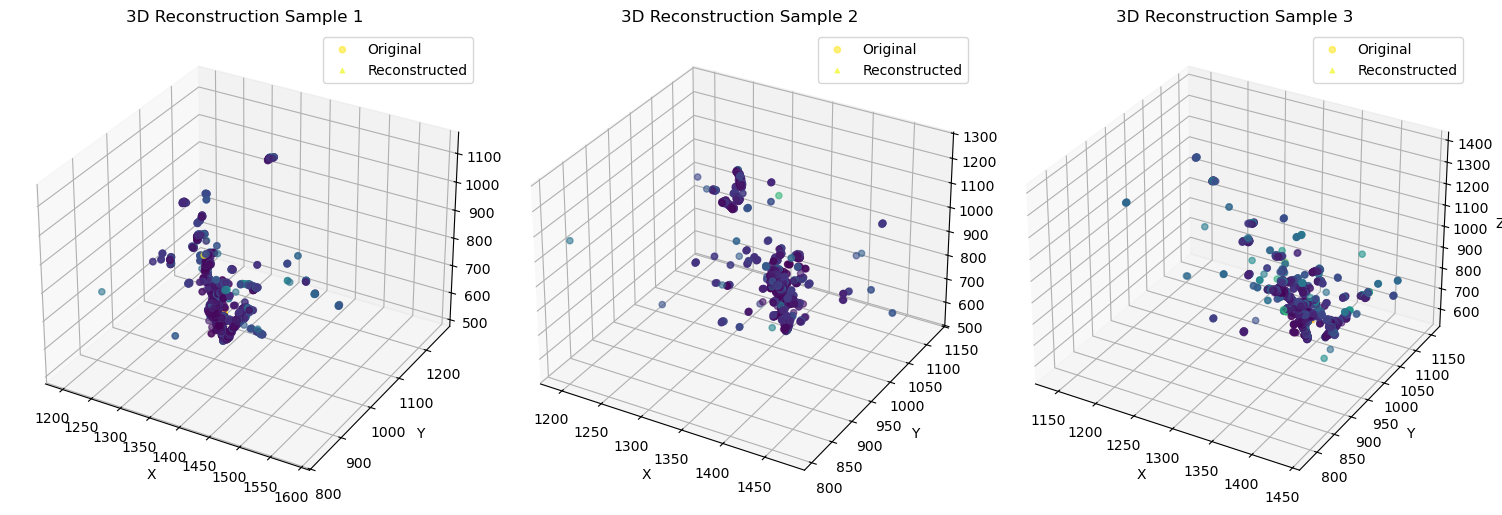

In [10]:
# Model Evaluation and Visualization

def evaluate_model(model, dataloader, device, scaler=None):
    """Evaluate model and return reconstruction losses"""
    model.eval()
    all_losses = []
    all_reconstructions = []
    all_originals = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = batch.to(device)
            mask = create_padding_mask(batch)
            
            # Get reconstructions
            reconstructed = model(batch, mask=mask)
            
            # Calculate per-sample losses
            batch_losses = []
            for i in range(batch.size(0)):
                sample_mask = mask[i]
                orig = batch[i][sample_mask]
                recon = reconstructed[i][sample_mask]
                
                sample_loss = F.mse_loss(recon, orig).item()
                batch_losses.append(sample_loss)
                
                # Store first few samples for visualization
                if len(all_reconstructions) < 10:
                    if scaler is not None:
                        orig_denorm = scaler.inverse_transform(orig.cpu().numpy())
                        recon_denorm = scaler.inverse_transform(recon.cpu().numpy())
                    else:
                        orig_denorm = orig.cpu().numpy()
                        recon_denorm = recon.cpu().numpy()
                        
                    all_originals.append(orig_denorm)
                    all_reconstructions.append(recon_denorm)
            
            all_losses.extend(batch_losses)
    
    return np.array(all_losses), all_originals, all_reconstructions

if all_events and 'model' in locals():
    print("Evaluating model on test set...")
    
    # Load best model
    try:
        checkpoint = torch.load('best_cnn_autoencoder.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded best model checkpoint")
    except:
        print("Using current model (no checkpoint found)")
    
    # Evaluate on test set
    test_losses, test_originals, test_reconstructions = evaluate_model(
        model, test_loader, device, scaler=train_dataset.scaler
    )
    
    print(f"\nTest Set Evaluation:")
    print(f"Number of test samples: {len(test_losses)}")
    print(f"Mean reconstruction loss: {test_losses.mean():.6f}")
    print(f"Std reconstruction loss: {test_losses.std():.6f}")
    print(f"Min reconstruction loss: {test_losses.min():.6f}")
    print(f"Max reconstruction loss: {test_losses.max():.6f}")
    
    # Plot reconstruction loss distribution
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(test_losses, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Reconstruction Loss')
    plt.ylabel('Frequency')
    plt.title('Test Reconstruction Loss Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.hist(test_losses, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Reconstruction Loss')
    plt.ylabel('Frequency')
    plt.title('Test Loss Distribution (Log Scale)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.boxplot(test_losses)
    plt.ylabel('Reconstruction Loss')
    plt.title('Test Loss Box Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Visualization of reconstructions
    if test_originals and test_reconstructions:
        print(f"\nVisualizing {len(test_reconstructions)} sample reconstructions...")
        
        # Plot several reconstruction examples
        n_examples = min(4, len(test_reconstructions))
        fig, axes = plt.subplots(n_examples, 4, figsize=(16, 4 * n_examples))
        
        if n_examples == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(n_examples):
            orig = test_originals[i]
            recon = test_reconstructions[i]
            
            # Feature plots
            features = ['X', 'Y', 'Z', 'Energy']
            for j in range(4):
                axes[i, j].plot(orig[:, j], 'b-', label='Original', alpha=0.7, linewidth=2)
                axes[i, j].plot(recon[:, j], 'r--', label='Reconstructed', alpha=0.7, linewidth=2)
                axes[i, j].set_title(f'Sample {i+1}: {features[j]}')
                axes[i, j].set_xlabel('Point Index (sorted by energy)')
                axes[i, j].set_ylabel(features[j])
                axes[i, j].legend()
                axes[i, j].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 3D scatter plots for spatial reconstruction
        fig = plt.figure(figsize=(15, 5))
        
        for i in range(min(3, len(test_reconstructions))):
            orig = test_originals[i]
            recon = test_reconstructions[i]
            
            ax = fig.add_subplot(1, 3, i+1, projection='3d')
            
            # Plot original points
            ax.scatter(orig[:, 0], orig[:, 1], orig[:, 2], 
                      c=orig[:, 3], cmap='viridis', alpha=0.6, s=20, label='Original')
            
            # Plot reconstructed points
            ax.scatter(recon[:, 0], recon[:, 1], recon[:, 2], 
                      c=recon[:, 3], cmap='plasma', alpha=0.6, s=10, marker='^', label='Reconstructed')
            
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title(f'3D Reconstruction Sample {i+1}')
            ax.legend()
        
        plt.tight_layout()
        plt.show()
    
else:
    print("No trained model available for evaluation")

Performing anomaly detection analysis...

Threshold: 90th percentile
  Threshold value: 1.052920
  Anomalies detected: 4/33 (12.1%)

Threshold: 95th percentile
  Threshold value: 1.143301
  Anomalies detected: 2/33 (6.1%)

Threshold: 99th percentile
  Threshold value: 1.269863
  Anomalies detected: 1/33 (3.0%)


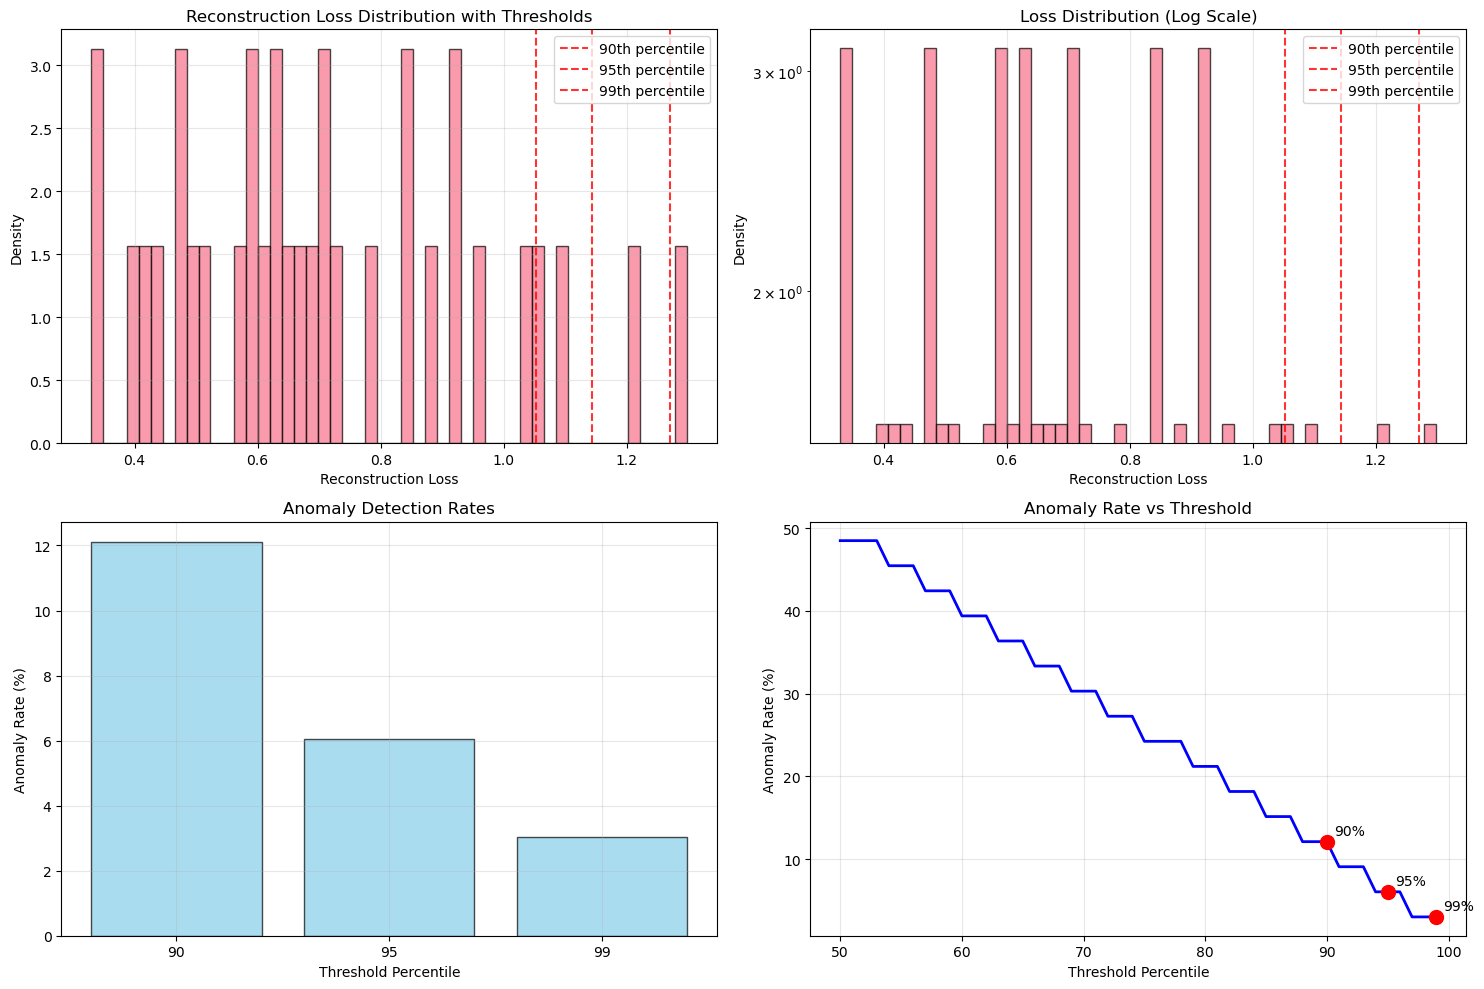


In visualization samples:
Normal events: 9
Anomalous events: 1


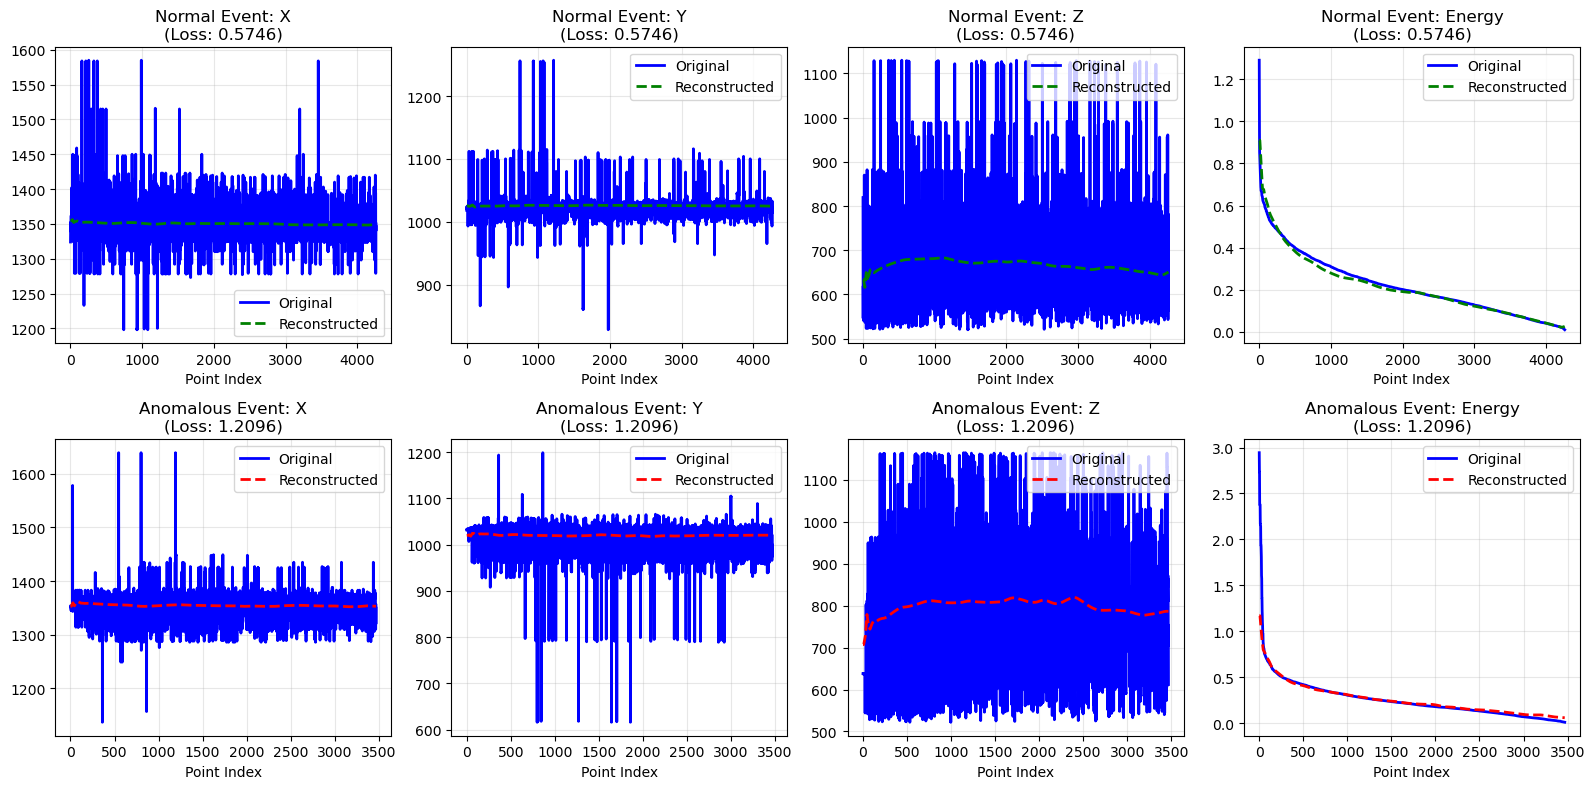


ANOMALY DETECTION SUMMARY
Total test samples: 33
Mean reconstruction loss: 0.712198
Std reconstruction loss: 0.247723

Recommended threshold (95th percentile): 1.143301
Expected anomaly rate: ~5%
Actual anomaly rate: 6.1%


In [11]:
# Anomaly Detection Analysis

def detect_anomalies(losses, threshold_percentile=95):
    """Detect anomalies based on reconstruction loss"""
    threshold = np.percentile(losses, threshold_percentile)
    anomaly_mask = losses > threshold
    return anomaly_mask, threshold

if all_events and 'test_losses' in locals():
    print("Performing anomaly detection analysis...")
    
    # Detect anomalies using different thresholds
    thresholds = [90, 95, 99]
    results = {}
    
    for thresh in thresholds:
        anomaly_mask, threshold_value = detect_anomalies(test_losses, thresh)
        n_anomalies = np.sum(anomaly_mask)
        
        results[thresh] = {
            'mask': anomaly_mask,
            'threshold': threshold_value,
            'n_anomalies': n_anomalies,
            'anomaly_rate': n_anomalies / len(test_losses) * 100
        }
        
        print(f"\nThreshold: {thresh}th percentile")
        print(f"  Threshold value: {threshold_value:.6f}")
        print(f"  Anomalies detected: {n_anomalies}/{len(test_losses)} ({results[thresh]['anomaly_rate']:.1f}%)")
    
    # Plot anomaly detection results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss distribution with thresholds
    axes[0, 0].hist(test_losses, bins=50, alpha=0.7, edgecolor='black', density=True)
    for thresh in thresholds:
        axes[0, 0].axvline(results[thresh]['threshold'], 
                          color='red', linestyle='--', alpha=0.8,
                          label=f'{thresh}th percentile')
    axes[0, 0].set_xlabel('Reconstruction Loss')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Reconstruction Loss Distribution with Thresholds')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Log scale version
    axes[0, 1].hist(test_losses, bins=50, alpha=0.7, edgecolor='black', density=True)
    for thresh in thresholds:
        axes[0, 1].axvline(results[thresh]['threshold'], 
                          color='red', linestyle='--', alpha=0.8,
                          label=f'{thresh}th percentile')
    axes[0, 1].set_xlabel('Reconstruction Loss')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Loss Distribution (Log Scale)')
    axes[0, 1].set_yscale('log')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Anomaly rates
    percentiles = list(results.keys())
    rates = [results[p]['anomaly_rate'] for p in percentiles]
    
    axes[1, 0].bar([str(p) for p in percentiles], rates, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].set_xlabel('Threshold Percentile')
    axes[1, 0].set_ylabel('Anomaly Rate (%)')
    axes[1, 0].set_title('Anomaly Detection Rates')
    axes[1, 0].grid(True, alpha=0.3)
    
    # ROC-like curve for different thresholds
    thresh_range = np.arange(50, 100, 1)
    anomaly_rates = []
    
    for t in thresh_range:
        _, thresh_val = detect_anomalies(test_losses, t)
        anomaly_rate = np.sum(test_losses > thresh_val) / len(test_losses) * 100
        anomaly_rates.append(anomaly_rate)
    
    axes[1, 1].plot(thresh_range, anomaly_rates, 'b-', linewidth=2)
    axes[1, 1].set_xlabel('Threshold Percentile')
    axes[1, 1].set_ylabel('Anomaly Rate (%)')
    axes[1, 1].set_title('Anomaly Rate vs Threshold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Mark common thresholds
    for thresh in [90, 95, 99]:
        if thresh in thresh_range:
            idx = list(thresh_range).index(thresh)
            axes[1, 1].scatter(thresh, anomaly_rates[idx], color='red', s=100, zorder=5)
            axes[1, 1].annotate(f'{thresh}%', 
                               (thresh, anomaly_rates[idx]), 
                               xytext=(5, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()
    
    # Show examples of detected anomalies vs normal events
    if test_originals and test_reconstructions:
        # Use 95th percentile threshold
        anomaly_mask = results[95]['mask']
        
        # Find indices of anomalies and normal events in our visualization samples
        n_viz_samples = len(test_reconstructions)
        viz_losses = test_losses[:n_viz_samples]
        viz_anomalies = anomaly_mask[:n_viz_samples]
        
        normal_indices = np.where(~viz_anomalies)[0]
        anomaly_indices = np.where(viz_anomalies)[0]
        
        print(f"\nIn visualization samples:")
        print(f"Normal events: {len(normal_indices)}")
        print(f"Anomalous events: {len(anomaly_indices)}")
        
        # Plot comparison if we have both types
        if len(normal_indices) > 0 and len(anomaly_indices) > 0:
            fig, axes = plt.subplots(2, 4, figsize=(16, 8))
            
            # Plot normal event
            normal_idx = normal_indices[0]
            orig_normal = test_originals[normal_idx]
            recon_normal = test_reconstructions[normal_idx]
            loss_normal = viz_losses[normal_idx]
            
            features = ['X', 'Y', 'Z', 'Energy']
            for j in range(4):
                axes[0, j].plot(orig_normal[:, j], 'b-', label='Original', linewidth=2)
                axes[0, j].plot(recon_normal[:, j], 'g--', label='Reconstructed', linewidth=2)
                axes[0, j].set_title(f'Normal Event: {features[j]}\n(Loss: {loss_normal:.4f})')
                axes[0, j].set_xlabel('Point Index')
                axes[0, j].legend()
                axes[0, j].grid(True, alpha=0.3)
            
            # Plot anomalous event
            anomaly_idx = anomaly_indices[0]
            orig_anomaly = test_originals[anomaly_idx]
            recon_anomaly = test_reconstructions[anomaly_idx]
            loss_anomaly = viz_losses[anomaly_idx]
            
            for j in range(4):
                axes[1, j].plot(orig_anomaly[:, j], 'b-', label='Original', linewidth=2)
                axes[1, j].plot(recon_anomaly[:, j], 'r--', label='Reconstructed', linewidth=2)
                axes[1, j].set_title(f'Anomalous Event: {features[j]}\n(Loss: {loss_anomaly:.4f})')
                axes[1, j].set_xlabel('Point Index')
                axes[1, j].legend()
                axes[1, j].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    # Summary statistics
    print(f"\n" + "="*50)
    print("ANOMALY DETECTION SUMMARY")
    print("="*50)
    print(f"Total test samples: {len(test_losses)}")
    print(f"Mean reconstruction loss: {test_losses.mean():.6f}")
    print(f"Std reconstruction loss: {test_losses.std():.6f}")
    print(f"\nRecommended threshold (95th percentile): {results[95]['threshold']:.6f}")
    print(f"Expected anomaly rate: ~5%")
    print(f"Actual anomaly rate: {results[95]['anomaly_rate']:.1f}%")
    
else:
    print("No test results available for anomaly detection analysis")

In [12]:
# Model Saving and Summary

if all_events and 'model' in locals():
    print("Saving final model and analysis results...")
    
    # Save final model state
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': CONFIG,
        'scaler': train_dataset.scaler,
        'train_losses': train_losses if 'train_losses' in locals() else [],
        'val_losses': val_losses if 'val_losses' in locals() else [],
        'test_losses': test_losses if 'test_losses' in locals() else [],
        'architecture': 'CNN1DAutoEncoder',
        'input_dim': CONFIG['feature_dim'],
        'latent_dim': CONFIG['latent_dim'],
        'max_points': CONFIG['max_points']
    }, 'final_cnn_autoencoder.pth')
    
    print("Model saved as 'final_cnn_autoencoder.pth'")
    
    # Create analysis summary
    summary = {
        'model_type': 'CNN 1D Autoencoder',
        'input_features': ['x', 'y', 'z', 'energy'],
        'data_preprocessing': 'Sorted by energy (descending), normalized with StandardScaler',
        'architecture': {
            'encoder_layers': 4,
            'decoder_layers': 4,
            'latent_dim': CONFIG['latent_dim'],
            'total_parameters': sum(p.numel() for p in model.parameters())
        },
        'training': {
            'epochs_trained': len(train_losses) if 'train_losses' in locals() else 0,
            'batch_size': CONFIG['batch_size'],
            'learning_rate': CONFIG['learning_rate'],
            'optimizer': 'Adam',
            'scheduler': 'ReduceLROnPlateau'
        },
        'performance': {
            'final_train_loss': train_losses[-1] if 'train_losses' in locals() and train_losses else 'N/A',
            'final_val_loss': val_losses[-1] if 'val_losses' in locals() and val_losses else 'N/A',
            'test_loss_mean': test_losses.mean() if 'test_losses' in locals() else 'N/A',
            'test_loss_std': test_losses.std() if 'test_losses' in locals() else 'N/A'
        },
        'anomaly_detection': {
            'recommended_threshold_percentile': 95,
            'threshold_value': results[95]['threshold'] if 'results' in locals() else 'N/A',
            'expected_anomaly_rate': '~5%'
        }
    }
    
    print("\n" + "="*60)
    print("FINAL MODEL SUMMARY")
    print("="*60)
    
    print(f"Model Type: {summary['model_type']}")
    print(f"Input Features: {', '.join(summary['input_features'])}")
    print(f"Data Preprocessing: {summary['data_preprocessing']}")
    
    print(f"\nArchitecture:")
    for key, value in summary['architecture'].items():
        print(f"  {key.replace('_', ' ').title()}: {value:,}" if isinstance(value, int) else f"  {key.replace('_', ' ').title()}: {value}")
    
    print(f"\nTraining:")
    for key, value in summary['training'].items():
        print(f"  {key.replace('_', ' ').title()}: {value}")
    
    print(f"\nPerformance:")
    for key, value in summary['performance'].items():
        if isinstance(value, float):
            print(f"  {key.replace('_', ' ').title()}: {value:.6f}")
        else:
            print(f"  {key.replace('_', ' ').title()}: {value}")
    
    print(f"\nAnomaly Detection:")
    for key, value in summary['anomaly_detection'].items():
        if isinstance(value, float):
            print(f"  {key.replace('_', ' ').title()}: {value:.6f}")
        else:
            print(f"  {key.replace('_', ' ').title()}: {value}")
    
    # Usage instructions
    print("\n" + "="*60)
    print("USAGE INSTRUCTIONS")
    print("="*60)
    print("""
To use this trained model for anomaly detection:

1. Load the model:
   checkpoint = torch.load('final_cnn_autoencoder.pth')
   model = CNN1DAutoEncoder(...)
   model.load_state_dict(checkpoint['model_state_dict'])
   scaler = checkpoint['scaler']

2. Preprocess new data:
   - Sort points by energy (descending)
   - Normalize using the saved scaler
   - Convert to torch tensor

3. Get reconstruction loss:
   with torch.no_grad():
       reconstructed = model(data)
       loss = F.mse_loss(reconstructed, data)

4. Detect anomalies:
   threshold = checkpoint['test_losses'].quantile(0.95)  # or use saved threshold
   is_anomaly = loss > threshold
   
Benefits of CNN approach vs Graph approach:
- Much faster inference (linear vs quadratic scaling)
- Lower memory usage (100x reduction for large events)
- Better scalability for events with 1000+ points
- Still captures spatial and energy patterns through sorting
    """)
    
else:
    print("No model available to save")

Saving final model and analysis results...
Model saved as 'final_cnn_autoencoder.pth'

FINAL MODEL SUMMARY
Model Type: CNN 1D Autoencoder
Input Features: x, y, z, energy
Data Preprocessing: Sorted by energy (descending), normalized with StandardScaler

Architecture:
  Encoder Layers: 4
  Decoder Layers: 4
  Latent Dim: 128
  Total Parameters: 5,283,588

Training:
  Epochs Trained: 38
  Batch Size: 16
  Learning Rate: 0.001
  Optimizer: Adam
  Scheduler: ReduceLROnPlateau

Performance:
  Final Train Loss: 2.827113
  Final Val Loss: 2.728626
  Test Loss Mean: 0.712198
  Test Loss Std: 0.247723

Anomaly Detection:
  Recommended Threshold Percentile: 95
  Threshold Value: 1.143301
  Expected Anomaly Rate: ~5%

USAGE INSTRUCTIONS

To use this trained model for anomaly detection:

1. Load the model:
   checkpoint = torch.load('final_cnn_autoencoder.pth')
   model = CNN1DAutoEncoder(...)
   model.load_state_dict(checkpoint['model_state_dict'])
   scaler = checkpoint['scaler']

2. Preprocess n